In [1]:
#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import preprocessing
import matplotlib.cm as cm
plt.style.use('seaborn')

In [2]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')
orders = pd.read_csv('data/orders.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [3]:
%%time
n_samples = 100000
user_ids = orders.user_id.unique().tolist()
users_selected = random.sample(user_ids,n_samples)
orders_ds = orders[orders.user_id.isin(users_selected)]
ids_ = orders_ds.merge(order_products,on = 'order_id')
pbu = ids_.merge(products, on = 'product_id').sort_values(by = ['user_id','order_id','add_to_cart_order'])[['user_id','order_id','product_id','product_name']]
print(pbu.shape)
pbu.head()

(16362763, 4)
Wall time: 41.3 s


,user_id,order_id,product_id,product_name
191599,7,23391,13198,85% Lean Ground Beef
235353,7,23391,42803,Organic Apple Slices
513656,7,23391,8277,Apple Honeycrisp Organic
172721,7,23391,37602,Mexican Coffee
180481,7,23391,40852,Lactose Free Fat Free Milk


In [4]:
%%time
listed_products = pbu.groupby('user_id').product_name.apply(list).reset_index()

print(f'Rows: {listed_products.shape[0]}')
listed_products.user_id = listed_products.user_id.astype(str)
listed_products.head()

Rows: 100000
Wall time: 12 s


0        [85% Lean Ground Beef, Organic Apple Slices, A...
1        [Bag of Organic Bananas, Green Beans, Organic ...
2        [Half & Half, Whole Wheat Pita Bread Loaves, L...
3        [Blue Corn Chip Bowls, Smoked Fresh Turkey Kie...
4        [Iceberg Garden Salad Blend, 100% Juice Apple ...
                               ...                        
99995    [Snack Sticks Chicken & Rice Recipe Dog Treats...
99996    [Organic Baby Spinach, Creamy Almond Butter, F...
99997    [Bag of Organic Bananas, Grilled Chicken Breas...
99998    [Large Alfresco Eggs, Gluten Free Apple Cinnam...
99999    [Diet Pepsi Pack, Calcium Enriched 100% Lactos...
Name: product_name, Length: 100000, dtype: object

In [5]:
%%time
#training model
tagged_products = listed_products.values.tolist()
products_by_user = [TaggedDocument(products, [order_id]) for order_id, products in tagged_products]

d2v_model = Doc2Vec(documents   = products_by_user,
                    vector_size = 60,
                    min_count   = 100,
                    workers     = 4
                   )

# comparing similarity
sample_ = str(users_selected[0])
return_3 = d2v_model.docvecs.most_similar([d2v_model[sample_]])[:4]
print(return_3)
# look into word2Vec what if the user first buys a bag of lemons what are the following recommendations

[('82103', 0.9999999403953552), ('20400', 0.6802561283111572), ('146632', 0.6558395624160767), ('19805', 0.6311178207397461)]
Wall time: 2min 41s


In [6]:
pbu = pbu[['user_id','product_name']]
sample  = pbu[pbu.user_id == int(return_3[0][0])]
compare1 = pbu[pbu.user_id == int(return_3[1][0])]
compare2 = pbu[pbu.user_id == int(return_3[2][0])]

print('NUMBER OF ITEMS',
    '\nSample products: ',len(sample),
      '\nCompare products 1: ',len(compare1),
      '\nCompare products 2: ',len(compare2))

comp = sample.merge(compare1, on = 'product_name', how = 'inner')
#comp = comp.merge(compare2, on = 'product_name', how = 'inner')
#comp[['order_id_x','order_id_y','order_id','product_name']]
comp

NUMBER OF ITEMS 
Sample products:  7 
Compare products 1:  9 
Compare products 2:  63


,user_id_x,product_name,user_id_y
0,82103,Organic Blackberries,20400


## Elbow plot

In [7]:
%%time
distorsions = []
clusters = list(range(1,11))
for k in clusters:
    kmeans = KMeans(n_clusters= k, init='k-means++', max_iter=100)
    kmeans.fit(d2v_model.docvecs.vectors_docs)
    distorsions.append(kmeans.inertia_)

Wall time: 2min 30s


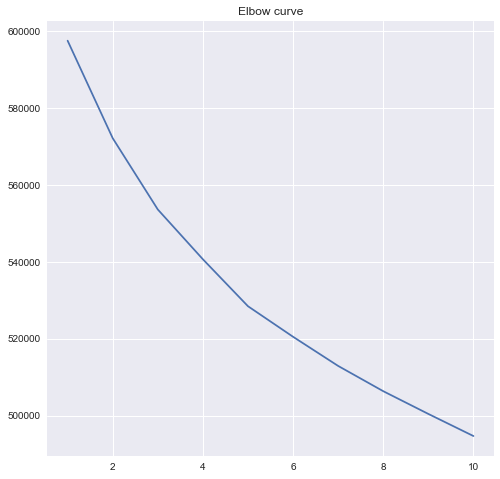

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.plot(clusters, distorsions)
plt.title('Elbow curve')
plt.show()

## Clustering

In [9]:
n_clusters_ = 3
#normalize docVecs before OR use cosine distance for KMeans
#Use DocVecs as features in stacking !!
kmeans_model = KMeans(n_clusters=n_clusters_, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
cluster_labels = kmeans_model.labels_
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

## Representing groups

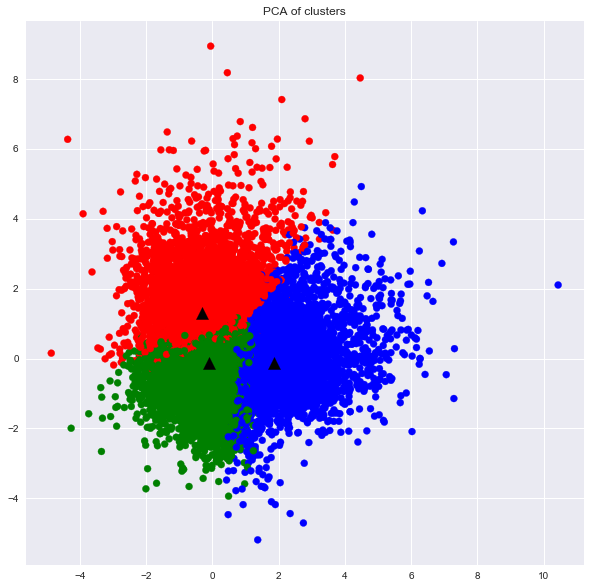

In [10]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in cluster_labels.tolist()]
plt.scatter(datapoint[:, 0], datapoint[:, 1],c = color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

## Silhouette analysis

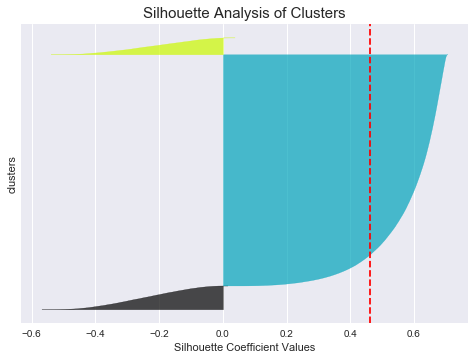

Wall time: 11min 16s


In [11]:
%%time
sample_silhouette_values = silhouette_samples(d2v_model.docvecs.vectors_docs, cluster_labels, metric='euclidean')

y_lower = 10

for i in range(n_clusters_):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    color = cm.nipy_spectral(float(i) / n_clusters_)
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color,edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10
    
silhouette_avg  = silhouette_score(d2v_model.docvecs.vectors_docs, cluster_labels)
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Analysis of Clusters', fontsize = 15)
plt.ylabel('clusters')
plt.yticks([])
plt.xlabel('Silhouette Coefficient Values')
plt.show()

# Analyzing clusters

In [12]:
listed_products['group'] = cluster_labels
listed_products.user_id = listed_products.user_id.astype(int)

order_user = orders[['order_id','user_id']]
lp_expanded = listed_products.merge(order_user, on = 'user_id')
lp_expanded = lp_expanded.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

,user_id,product_name_x,group,order_id,product_id,add_to_cart_order,reordered,product_name_y,aisle_id,department_id
0,7,"[85% Lean Ground Beef, Organic Apple Slices, A...",0,2565571,45628,1,0,Mango Rosewater Lassi Yogurt Drink,120,16
1,7,"[85% Lean Ground Beef, Organic Apple Slices, A...",0,121053,45628,7,1,Mango Rosewater Lassi Yogurt Drink,120,16
2,7,"[85% Lean Ground Beef, Organic Apple Slices, A...",0,2507052,45628,3,1,Mango Rosewater Lassi Yogurt Drink,120,16
3,7,"[85% Lean Ground Beef, Organic Apple Slices, A...",0,1396119,45628,2,1,Mango Rosewater Lassi Yogurt Drink,120,16
4,7,"[85% Lean Ground Beef, Organic Apple Slices, A...",0,565870,45628,2,1,Mango Rosewater Lassi Yogurt Drink,120,16


## cart size by group

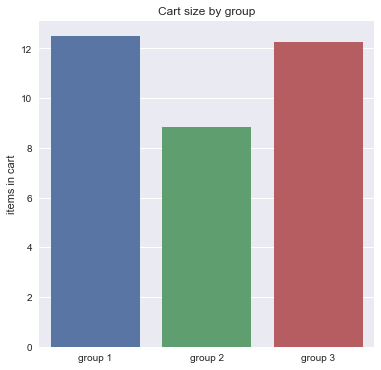

In [13]:
avg_cart_size_g1 = group_1.groupby('order_id').count().mean()[0]
avg_cart_size_g2 = group_2.groupby('order_id').count().mean()[0]
avg_cart_size_g3 = group_3.groupby('order_id').count().mean()[0]
avg_carts = [avg_cart_size_g1,avg_cart_size_g2,avg_cart_size_g3]

fig = plt.figure(figsize=(6, 6))
sns.barplot(x = ['group 1','group 2','group 3'],
            y = avg_carts)
plt.title('Cart size by group')
plt.ylabel('items in cart')
plt.show()

## Top departments for each group

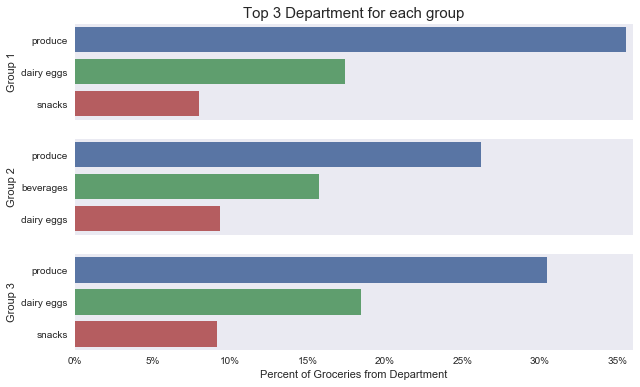

In [14]:
#group 1
t3_dept_g1_count = group_1.department_id.value_counts()[:3]/len(group_1.aisle_id)
t3_dept_g1 = departments[departments.department_id.isin(t3_dept_g1_count.index.to_list())].department

#group 2
t3_dept_g2_count = group_2.department_id.value_counts()[:3]/len(group_2.aisle_id)
t3_dept_g2 = departments[departments.department_id.isin(t3_dept_g2_count.index.to_list())].department

#group 3
t3_dept_g3_count = group_3.department_id.value_counts()[:3]/len(group_3.aisle_id)
t3_dept_g3 = departments[departments.department_id.isin(t3_dept_g3_count.index.to_list())].department

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.36
#group 1
plt.subplot(311)
plt.title('Top 3 Department for each group', fontsize = 15)
g1 = sns.barplot(x = t3_dept_g1_count.tolist(), y = t3_dept_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_dept_g2_count.tolist(), y = t3_dept_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_dept_g3_count.tolist(), y = t3_dept_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Department')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## Top Aisles for each group

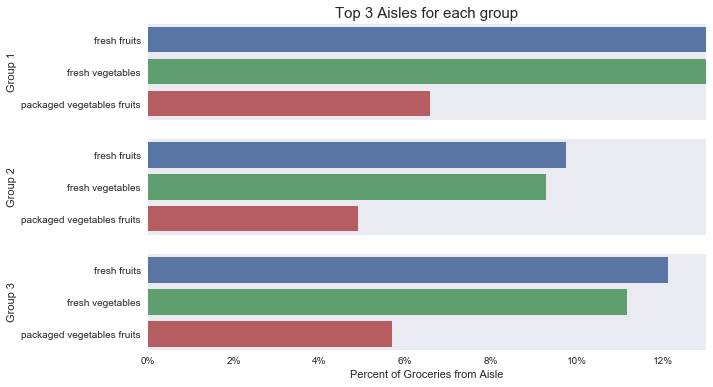

In [15]:
#group 1
t3_aisles_g1_count = group_1.aisle_id.value_counts()[:3]/len(group_1.aisle_id)
t3_aisles_g1 = aisles[aisles.aisle_id.isin(t3_aisles_g1_count.index.to_list())].aisle

#group 2
t3_aisles_g2_count = group_2.aisle_id.value_counts()[:3]/len(group_2.aisle_id)
t3_aisles_g2 = aisles[aisles.aisle_id.isin(t3_aisles_g2_count.index.to_list())].aisle

#group 3
t3_aisles_g3_count = group_3.aisle_id.value_counts()[:3]/len(group_3.aisle_id)
t3_aisles_g3 = aisles[aisles.aisle_id.isin(t3_aisles_g3_count.index.to_list())].aisle

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.13
#group 1
plt.subplot(311)
plt.title('Top 3 Aisles for each group', fontsize = 15)
g1 = sns.barplot(x = t3_aisles_g1_count.tolist(), y = t3_aisles_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_aisles_g2_count.tolist(), y = t3_aisles_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_aisles_g3_count.tolist(), y = t3_aisles_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Aisle')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## top products in each cluster

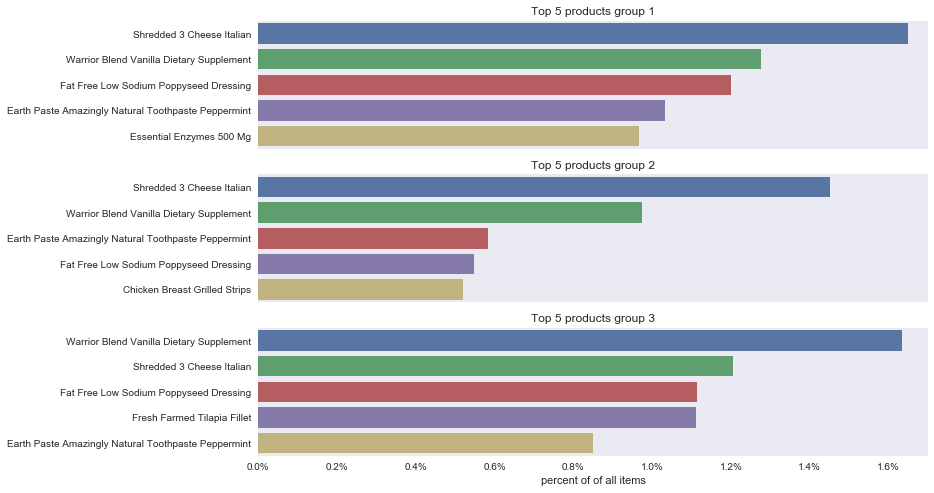

In [16]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---

## Word Vector Analysis

In [17]:
selected_ = pbu[pbu.user_id == int(tagged_products[0][0])]
selected_.head()

,user_id,product_name
191599,7,85% Lean Ground Beef
235353,7,Organic Apple Slices
513656,7,Apple Honeycrisp Organic
172721,7,Mexican Coffee
180481,7,Lactose Free Fat Free Milk


In [18]:
for pn in selected_.product_name:
    try:
        print('\nSelected Word: ',pn,
              '\nWord2Vec similar words: \n',
              d2v_model.wv.most_similar(pn)[0][0],
              '\n',
              d2v_model.wv.most_similar(pn)[1][0],
              '\n',
              d2v_model.wv.most_similar(pn)[2][0]
             )
    except Exception as e:
        print('\n\n')
        print(f'word {pn} did not meet minimum threshold')
          


Selected Word:  85% Lean Ground Beef 
Word2Vec similar words: 
 Soft Potato Bread 
 Boneless Beef Sirloin Steak 
 Boneless Skinless Chicken Breasts

Selected Word:  Organic Apple Slices 
Word2Vec similar words: 
 Aged White Cheddar Baked Rice & Corn Puffs Gluten Free Lunch Packs 
 Mild Cheddar Cheese Sticks 
 Organic AppleApple

Selected Word:  Apple Honeycrisp Organic 
Word2Vec similar words: 
 Organic Gala Apples 
 Organic Large Extra Fancy Fuji Apple 
 Organic Whole String Cheese

Selected Word:  Mexican Coffee 
Word2Vec similar words: 
 Cold-Brew Vanilla Coffee 
 Cold Brew Coffee With Coconut Milk 
 Organic Iced Black Coffee

Selected Word:  Lactose Free Fat Free Milk 
Word2Vec similar words: 
 Lactose Free 2% Reduced Fat Milk 
 Double Fiber Bread 
 Lactose Free Half & Half

Selected Word:  Seedless Red Grapes 
Word2Vec similar words: 
 Bartlett Pears 
 Strawberries 
 Honeycrisp Apple

Selected Word:  Large Pineapple Chunks 
Word2Vec similar words: 
 Jumbo Lump Crab Cake 
 All Nat


Selected Word:  Organic Strawberries 
Word2Vec similar words: 
 Organic Bartlett Pear 
 Organic Green Seedless Grapes 
 Organic Kiwi

Selected Word:  Organic Blueberries 
Word2Vec similar words: 
 Organic Blackberries 
 Blueberries 
 Organic Mango

Selected Word:  Mexican Coffee 
Word2Vec similar words: 
 Cold-Brew Vanilla Coffee 
 Cold Brew Coffee With Coconut Milk 
 Organic Iced Black Coffee

Selected Word:  Apple Honeycrisp Organic 
Word2Vec similar words: 
 Organic Gala Apples 
 Organic Large Extra Fancy Fuji Apple 
 Organic Whole String Cheese

Selected Word:  Vanilla Coffee Concentrate 
Word2Vec similar words: 
 Cold-Brew Black Coffee 
 Organic Mocha Coffee Concentrate 
 Cold-Brew Vanilla Coffee

Selected Word:  Lactose Free Fat Free Milk 
Word2Vec similar words: 
 Lactose Free 2% Reduced Fat Milk 
 Double Fiber Bread 
 Lactose Free Half & Half

Selected Word:  85% Lean Ground Beef 
Word2Vec similar words: 
 Soft Potato Bread 
 Boneless Beef Sirloin Steak 
 Boneless Skinless Chi


Selected Word:  Organic Russet Potato 
Word2Vec similar words: 
 Organic Red Potatoes 
 Organic Red Potato 
 Gold Potato

Selected Word:  Shredded Mild Cheddar Cheese 
Word2Vec similar words: 
 Taco Seasoning 
 New Mexico Taco Skillet Sauce For Chicken 
 Mild Salsa

Selected Word:  Mexican Coffee 
Word2Vec similar words: 
 Cold-Brew Vanilla Coffee 
 Cold Brew Coffee With Coconut Milk 
 Organic Iced Black Coffee

Selected Word:  Lactose Free Fat Free Milk 
Word2Vec similar words: 
 Lactose Free 2% Reduced Fat Milk 
 Double Fiber Bread 
 Lactose Free Half & Half

Selected Word:  Organic Strawberries 
Word2Vec similar words: 
 Organic Bartlett Pear 
 Organic Green Seedless Grapes 
 Organic Kiwi

Selected Word:  Vanilla Coffee Concentrate 
Word2Vec similar words: 
 Cold-Brew Black Coffee 
 Organic Mocha Coffee Concentrate 
 Cold-Brew Vanilla Coffee

Selected Word:  Organic Baby Carrots 
Word2Vec similar words: 
 Organic Peeled Whole Baby Carrots 
 Sea Salt Pita Chips 
 Organic Egg Whites



Selected Word:  Organic Cilantro 
Word2Vec similar words: 
 Bunched Cilantro 
 Tomatillo 
 Organic Cilantro Bunch

Selected Word:  Organic Dark Brown Sugar 
Word2Vec similar words: 
 Aluminum Free Baking Powder 
 Vanilla Extract, Pure, Madagascar 
 Organic Unsulphured Molasses

Selected Word:  The Original Worcestershire Sauce 
Word2Vec similar words: 
 Dijon Mustard 
 Original Bar BBQ Sauce 
 Double Superfine Mustard Powder, Original English

Selected Word:  Organic Unbleached All-Purpose Flour 
Word2Vec similar words: 
 Organic Powdered Sugar 
 Cane Sugar 
 Organic Unbleached Bread Flour

Selected Word:  Large Pineapple Chunks 
Word2Vec similar words: 
 Jumbo Lump Crab Cake 
 All Natural Whole Wheat Bread 
 Organic Free Range Large Grade A Brown Eggs



word Seasoning Allspice did not meet minimum threshold

Selected Word:  Organic Free Range Low Sodium Chicken Broth 
Word2Vec similar words: 
 Organic Free Range Chicken Broth 
 Organic Low Sodium Chicken Cooking Stock 
 Organic Beef

In [19]:
d2v_model.wv.most_similar('yellow onions')

KeyError: "word 'yellow onions' not in vocabulary"

In [ ]:
d2v_model.wv.most_similar('yellow bell pepper')

In [ ]:
d2v_model.wv.most_similar('green beans')

---

## Stacking with the vectorized model

In [31]:
vecs_df = pd.DataFrame(d2v_model.docvecs.vectors_docs)
vecs_df.columns = ['vec_' + str(col+1) for col in vecs_df.columns]
vecs_df['order_id'] = listed_products.user_id

orders = orders[['order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
stacked_df = orders.merge(vecs_df,on = 'order_id')
#stacked_df = stacked_df.drop('order_id',axis = 1)
print(f'Number of rows: {stacked_df.shape[0]} \nnumber of columns: {stacked_df.shape[1]}')
stacked_df.days_since_prior_order = stacked_df.days_since_prior_order.fillna(0)
stacked_df.head()

Number of rows: 100000 
number of columns: 65


,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,vec_1,vec_2,vec_3,vec_4,vec_5,...,vec_51,vec_52,vec_53,vec_54,vec_55,vec_56,vec_57,vec_58,vec_59,vec_60
0,94891,4,5,13,15.0,-0.013585,-0.127232,-0.416648,-0.232032,0.104139,...,0.105736,-0.013649,0.036189,-0.197012,-0.003933,0.079176,-0.128804,0.149942,-0.138651,0.025941
1,157374,4,1,18,19.0,0.275205,-0.123000,0.061190,-0.171500,0.087428,...,0.054614,0.144372,-0.286123,-0.021283,-0.060769,0.210914,-0.339810,-0.274453,0.016172,-0.503099
2,121053,3,0,18,30.0,0.180108,-0.251806,-0.367394,-0.313020,0.173902,...,-0.060110,-0.223377,0.266018,-0.194285,-0.133380,0.635586,-0.029475,0.272129,0.183868,-0.177154
3,23391,17,0,10,28.0,0.007609,-0.764336,-0.598092,-0.228723,-0.068196,...,0.204215,-0.058597,-0.152740,-0.499151,0.168512,-0.247732,0.255185,0.232265,-0.947227,0.689999
4,68288,2,5,15,30.0,0.008234,0.143596,0.106650,-0.324713,-0.142146,...,-0.105304,0.126256,-0.092888,0.116969,-0.099123,0.083193,0.205875,-0.102392,-0.177117,0.034898


##### department percentages

In [23]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')
orders = pd.read_csv('data/orders.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [24]:
merge_dfs = orders.merge(order_products, on = 'order_id')
merge_dfs = merge_dfs.merge(products, on = 'product_id')
merge_dfs.head()
pbu = merge_dfs.merge(departments, on = 'department_id').sort_values(by = ['user_id','order_id','add_to_cart_order'])
print('Shape: ',pbu.shape)
pbu.head()

Shape:  (33819106, 14)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages
8435246,431534,1,prior,5,4,15,28.0,12427,2,1,Original Beef Jerky,23,19,snacks
8444601,431534,1,prior,5,4,15,28.0,10258,3,1,Pistachios,117,19,snacks
2820656,431534,1,prior,5,4,15,28.0,25133,4,1,Organic String Cheese,21,16,dairy eggs
12611236,431534,1,prior,5,4,15,28.0,10326,5,0,Organic Fuji Apples,24,4,produce


In [33]:
pbu_dept = pbu[['user_id','department_id']]
pbu_dept = pbu_dept.groupby(['user_id','department_id']).agg({'department_id':'count'})\
.rename(columns = {'department_id':'dept_'})
pbu_dept = pbu_dept.unstack(level = 1, fill_value = 0)
pbu_dept = pbu_dept.astype(int)
pbu_dept = pbu_dept.reset_index()
pbu_dept.columns = [str(col[0]) + str(col[1]) for col in pbu_dept.columns]

pbu_dept["total_purchases"] = pbu_dept.loc[:,'dept_1':'dept_21'].sum(axis=1)
minimum_orders = 10
pbu_dept = pbu_dept[pbu_dept["total_purchases"] >= minimum_orders]
print(pbu_dept.shape)
pbu_dept = pbu_dept.loc[:,'dept_1':'dept_21'].div(pbu_dept["total_purchases"], axis=0) *100
pbu_dept['user_id'] = pbu.user_id
pbu_dept.head()

(202493, 23)


,dept_1,dept_2,dept_3,dept_4,dept_5,dept_6,dept_7,dept_8,dept_9,dept_10,...,dept_13,dept_14,dept_15,dept_16,dept_17,dept_18,dept_19,dept_20,dept_21,user_id
0,0.000000,0.0,0.000000,7.142857,0.000000,0.000000,21.428571,0.0,0.000000,0.0,...,1.428571,5.714286,0.000000,24.285714,4.285714,0.0,35.714286,0.000000,0.0,1
1,12.389381,0.0,0.884956,19.026549,0.000000,1.327434,3.982301,0.0,0.000000,0.0,...,4.867257,1.327434,1.769912,21.681416,0.000000,0.0,20.796460,10.619469,0.0,1
2,6.818182,0.0,0.000000,43.181818,0.000000,0.000000,3.409091,0.0,4.545455,0.0,...,4.545455,0.000000,0.000000,23.863636,1.136364,0.0,10.227273,2.272727,0.0,1
3,16.666667,0.0,11.111111,11.111111,11.111111,0.000000,16.666667,0.0,0.000000,0.0,...,0.000000,0.000000,5.555556,0.000000,11.111111,0.0,5.555556,11.111111,0.0,1
4,4.347826,0.0,0.000000,50.000000,0.000000,8.695652,0.000000,0.0,2.173913,0.0,...,6.521739,0.000000,2.173913,19.565217,2.173913,0.0,2.173913,2.173913,0.0,1


In [26]:
stacked_df = pd.DataFrame(preprocessing.scale(vecs_df))
stacked_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-1.202308,-0.527240,-0.792165,0.527229,0.879998,1.151729,-2.176222,-0.036873,-1.589860,-0.649899,...,-0.649201,-1.624545,-1.447448,0.569025,-0.665610,-1.241164,-0.253168,-0.211557,0.865836,-1.725024
1,-0.876538,-0.140642,0.352559,0.475369,-0.232518,0.103721,-0.580796,0.247513,1.308952,-0.495211,...,0.540308,-0.135841,-0.316094,0.241853,0.193850,0.467130,-0.173675,-0.086365,-0.407687,-1.724940
2,0.911996,-0.527226,0.489541,1.016902,0.690241,-0.145948,0.851470,-0.093831,-0.614592,0.141981,...,0.129897,0.509644,-0.841246,-0.774233,0.721729,0.526429,-0.379810,-0.127450,-0.331705,-1.724923
3,0.078172,0.032279,0.556239,0.024779,0.577062,0.124716,-0.502177,0.262106,0.108664,-0.278880,...,0.329415,0.117657,0.124548,0.231503,-0.282730,0.483036,-0.182886,-0.197652,0.567910,-1.724839
4,0.321948,0.418923,-0.067182,0.156908,-0.033010,-0.063408,-0.272956,-0.049580,0.129581,-0.187096,...,0.171508,0.103060,-0.614790,0.361675,-0.203416,0.020175,0.506890,-0.278894,-0.126754,-1.724823


In [27]:
cluster_num = 10
kmeans_stacking = KMeans(n_clusters=cluster_num, init='k-means++', max_iter=100) 
X_stacked = kmeans_stacking.fit(X = stacked_df)
stacked_cluster_labels = kmeans_stacking.labels_
pca = PCA(n_components=2).fit(stacked_df)
stacked_datapoint = pca.transform(stacked_df)

In [28]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in stacked_cluster_labels.tolist()]
plt.scatter(stacked_datapoint[:, 0], stacked_datapoint[:, 1],c = color)
centroids = kmeans_stacking.cluster_centers_
stacked_centroidpoint = pca.transform(centroids)
plt.scatter(stacked_centroidpoint[:, 0], stacked_centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

IndexError: list index out of range

<Figure size 720x720 with 0 Axes>

In [ ]:
listed_products['group'] = stacked_cluster_labels
listed_products.order_id = listed_products.order_id.astype(int)
lp_expanded = listed_products.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

In [ ]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---